## The Goal
- learn how `PyTorch 2.0` is different than `PyTorch 1.0`
  - main added feature is speed

- Test this with use of `torch.compile(model)` and without when trainign a model

In [ ]:
import torch
import torchvision

model = torchvision.models.resnet50() # note: this could be any model
compiled_model = torch.compile(model) # <- magic happens! for PyTorch 2.0

### Train model ### <- faster!

### Test model ### <- faster!

## Setup

In [1]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.5.1+cu121 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


In [9]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Mon Jan 13 16:18:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              31W /  70W |    103MiB / 153

In [3]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [31]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally
torch.set_default_device(device)

# All tensors created will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


## Expereiements plan
- Model: ResNet50 (from TorchVision)
- Data: CIFAR10 (from TorchVision)
- Epochs: 5 (single run) and 3x5 (multiple runs)
- Batch size: 32 (*since the GPU i use has 15 GB RAM*)
- Image size: 128 (*since the GPU i use has 15 GB RAM*)

each with and without `torch.compile()`

## Setup

In [1]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
Using device: cuda


In [2]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, transforms

In [3]:
model, transforms = create_model()
# model, transforms
# transforms

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [4]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.728 GB
Total GPU memory: 15.836 GB


In [5]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 15.728 GB, using batch size of 32 and image size 128


In [6]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)


### Get Dataset

In [11]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False, # want the test split
                                            download=True,
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [12]:
from torch.utils.data import DataLoader

# Create DataLoaders
import os
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32
Using number of workers: 2 (generally more workers means faster dataloading from CPU to GPU)


### Training and Testing loops

In [19]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)


      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

In [15]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

### Experiement 1
- Model: ResNet50 (from TorchVision)
- Data: CIFAR10 (from TorchVision)
- Epochs: 5
- Batch size: 32
- Image size: 128
- without `torch.compile()`

In [20]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1353 | train_acc: 0.5977 | test_loss: 0.8697 | test_acc: 0.7021 | train_epoch_time: 190.2805 | test_epoch_time: 15.6785


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6898 | train_acc: 0.7603 | test_loss: 0.6494 | test_acc: 0.7791 | train_epoch_time: 191.8287 | test_epoch_time: 16.1605


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5338 | train_acc: 0.8173 | test_loss: 0.5195 | test_acc: 0.8208 | train_epoch_time: 190.2764 | test_epoch_time: 15.4206


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4237 | train_acc: 0.8542 | test_loss: 0.5038 | test_acc: 0.8264 | train_epoch_time: 189.6732 | test_epoch_time: 15.7329


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3350 | train_acc: 0.8837 | test_loss: 0.5261 | test_acc: 0.8301 | train_epoch_time: 188.5715 | test_epoch_time: 15.6119


### Experiement 2
- Model: ResNet50 (from TorchVision)
- Data: CIFAR10 (from TorchVision)
- Epochs: 5
- Batch size: 32
- Image size: 128
- with `torch.compile()`

In [24]:
!pip install triton

In [27]:
import torch._dynamo
torch._dynamo.config.suppress_errors = False

In [28]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.0009582042694091797 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1779 | train_acc: 0.5769 | test_loss: 0.9161 | test_acc: 0.6820 | train_epoch_time: 192.4257 | test_epoch_time: 15.3803


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7223 | train_acc: 0.7484 | test_loss: 0.7838 | test_acc: 0.7348 | train_epoch_time: 191.4638 | test_epoch_time: 18.4401


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5449 | train_acc: 0.8115 | test_loss: 0.5441 | test_acc: 0.8102 | train_epoch_time: 190.2248 | test_epoch_time: 15.4798


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4273 | train_acc: 0.8527 | test_loss: 0.4779 | test_acc: 0.8384 | train_epoch_time: 189.5723 | test_epoch_time: 16.1022


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3449 | train_acc: 0.8802 | test_loss: 0.4945 | test_acc: 0.8342 | train_epoch_time: 190.3297 | test_epoch_time: 15.4232


### Comparing Experiement 1 Vs Experiement 2

In [29]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [30]:
single_run_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.177871,0.576915,0.916055,0.682009,192.425667,15.380304
1,0.722269,0.748361,0.783751,0.734824,191.463803,18.440052
2,0.544931,0.811540,0.544147,0.810204,190.224767,15.479755
3,0.427259,0.852667,0.477896,0.838359,189.572315,16.102189
4,0.344942,0.880238,0.494547,0.834165,190.329749,15.423191


In [31]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: 0.356% (negative means faster)
Mean test epoch time difference: 2.826% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_Tesla_T4_ResNet50_CIFAR10_128_train_epoch_time.png


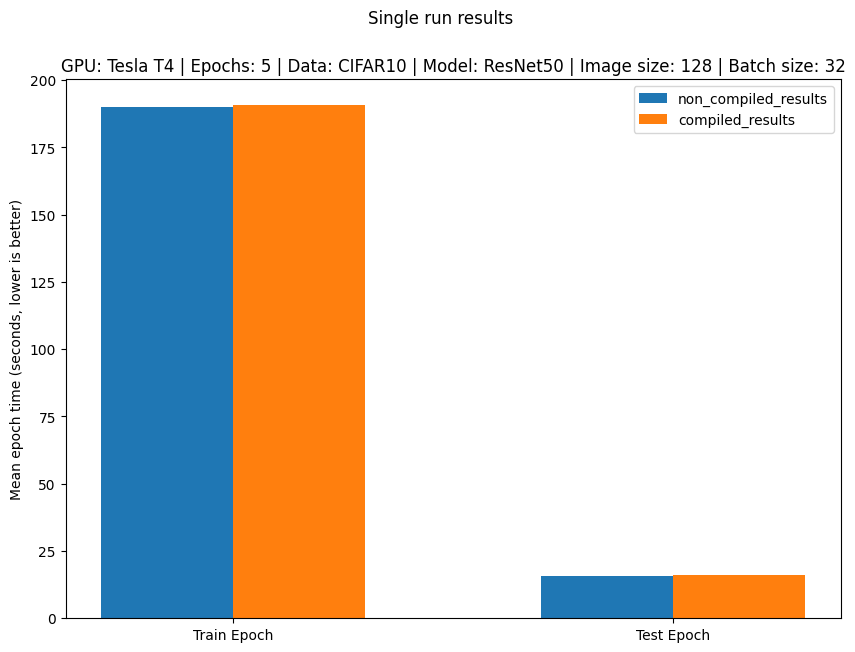

In [33]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_multi_run,
                      save=True)

In [34]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_Tesla_T4.csv


### Possible more experiements (Not Done yet)
- could see noticable effects of `torch.compile()` with more epochs, because of the **additional time upfront** during compiling the model


#### Experiement 3
- Model: ResNet50 (from TorchVision)
- Data: CIFAR10 (from TorchVision)
- Epochs: 3 * 5 (**multiple runs**)
- Batch size: 32
- Image size: 128
- without `torch.compile()`

### Experiement 4
- Model: ResNet50 (from TorchVision)
- Data: CIFAR10 (from TorchVision)
- Epochs: 3 * 5 (**multiple runs**)
- Batch size: 32
- Image size: 128
- with `torch.compile()`

In [ ]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)

    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)

    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)

    return compile_results